In [46]:
import random 
import requests
import pandas as pd
from itertools import product

# URL til SSB API for tabell 03024
api_url = "https://data.ssb.no/api/v0/no/table/03024/"

# Definerer API-spørringen
query = {
    "query": [],
    "response": {
        "format": "json-stat2"
    }
}

# Hente data fra API
response = requests.post(api_url, json=query)

# Sjekke om forespørselen var vellykket
if response.status_code == 200:
    data = response.json()
    
    # Ekstrahere dimensjonsnavn og verdier
    dimension_names = list(data["dimension"].keys())
    values = data["value"]
    
    # Opprette en liste av kombinasjoner av dimensjoner
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    
    # Generere alle kombinasjoner av dimensjonsverdier
    all_combinations = list(product(*dimensions))
    
    # Lage en DataFrame med riktige dimensjoner
    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values  # Knytte verdiene til riktige rader
    
    # Pivotere data for å få ønsket struktur
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()
    
    # Gi kolonnene mer forståelige navn med riktig rekkefølge
    df_pivot.columns = ["Tid", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)", "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]
    

#lager tilfedlige null-verdier i datasettet
    for i in range(len(df_pivot) // 10):  # Sett null på ca. 10% av radene
        row_idx = random.randint(0, len(df_pivot) - 1)  #Velger en tilfeldig rad
        col_idx = random.choice(["Fersk laks - Vekt (tonn)", "Frosset laks - Vekt (tonn)", "Fersk laks - Kilospris", "Frosset laks - Kilospris"])  # Velg en tilfeldig kolonne
        df_pivot.at[row_idx, col_idx] = float("nan") #Setter verdien til null




#Konverter "Tid" til str og fjern "U"
    df_pivot["År"] = df_pivot["Tid"].str[:4].astype(int) # Første 4 tegn er årstall
    df_pivot["Uke"] = df_pivot["Tid"].str[5:].astype(int)  # Etter "U" er uke

#Fjern den opprinnelige "Tid"-kolonnen
    df_pivot = df_pivot.drop(columns=["Tid"])

#Flytt "ÅrUke" først i datasettet
    df_pivot = df_pivot[["Uke"] + [col for col in df_pivot.columns if col not in ["Uke"]]]
    df_pivot = df_pivot[["År"] + [col for col in df_pivot.columns if col not in ["År"]]]

    
#Hvis du vil kombinere "År" og "Uke" til en kolonne men det er ikke lurt når man skal plotte data   
#Lag en ny kolonne "ÅrUke" med format YYYYWW
    #df_pivot["År/Uke"] = df_pivot["År"].astype(str) + df_pivot["Uke"].astype(str).str.zfill(2)
    #df_pivot = df_pivot.drop(columns=["År", "Uke"])



#Skriver ut data
    print(df_pivot.to_string(index=True))

    print("Data hentet, sortert og formatert for visning.")
else:
    print(f"Feil ved henting av data: {response.status_code}")
    print(response.text)  #Skriver ut feilmeldingen fra API-et




        År  Uke  Fersk laks - Kilospris  Fersk laks - Vekt (tonn)  Frosset laks - Kilospris  Frosset laks - Vekt (tonn)
0     2000    1                   30.98                    3728.0                     32.54                       383.0
1     2000    2                   31.12                    4054.0                     33.63                       216.0
2     2000    3                   31.03                    4043.0                     36.06                       633.0
3     2000    4                   30.95                    3730.0                     34.27                       393.0
4     2000    5                   31.30                    3831.0                     33.91                       453.0
5     2000    6                   32.53                    4415.0                     35.30                       265.0
6     2000    7                   32.46                    4617.0                     34.49                         NaN
7     2000    8                   32.19 

In [48]:
null_verdier = df_pivot.isnull()
#print(null_verdier)

renset_data = df_pivot.dropna() #Fjerner rader med null-verdier
#print(renset_data.to_string(index=True))


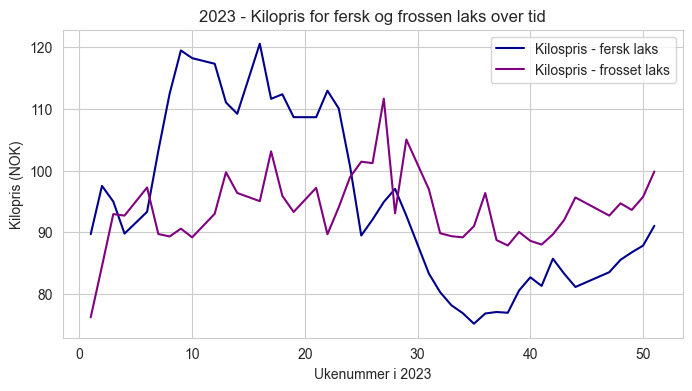

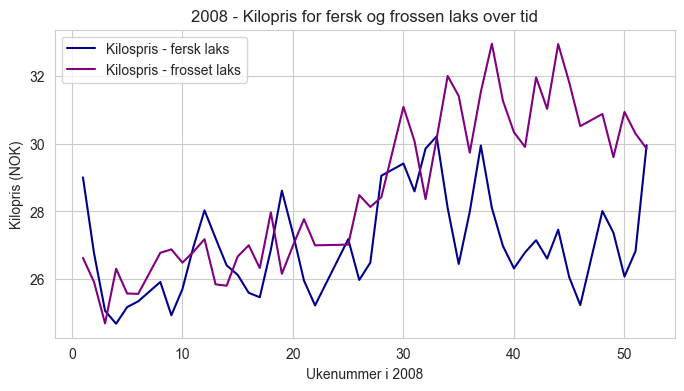

In [49]:
#Lager et plott bare for alle ukene i 2008 og 2023
import matplotlib.pyplot as plt
import seaborn as sns

#for 2023
fig, ax = plt.subplots(figsize=(8, 4))

df_2023 = renset_data[renset_data["År"] == 2023]  # Behold kun radene hvor År er 2023
sns.lineplot (data=df_2023, x = "Uke", y = "Fersk laks - Kilospris", color = "darkblue", label = "Kilospris - fersk laks")
sns.lineplot (data=df_2023, x = "Uke", y = "Frosset laks - Kilospris", color = "purple", label = "Kilospris - frosset laks")

ax.set_title("2023 - Kilopris for fersk og frossen laks over tid")
ax.set_xlabel("Ukenummer i 2023")
ax.set_ylabel("Kilopris (NOK)")
ax.legend()  

plt.grid(True)

#for 2008
fig, ax = plt.subplots(figsize=(8, 4))
df_2008 = renset_data[renset_data["År"] == 2008]  # Behold kun radene hvor År er 2023

sns.lineplot (data=df_2008, x = "Uke", y = "Fersk laks - Kilospris", color = "darkblue", label = "Kilospris - fersk laks")
sns.lineplot (data=df_2008, x = "Uke", y = "Frosset laks - Kilospris", color = "purple", label = "Kilospris - frosset laks")

ax.set_title("2008 - Kilopris for fersk og frossen laks over tid")
ax.set_xlabel("Ukenummer i 2008")
ax.set_ylabel("Kilopris (NOK)")
ax.legend()  

plt.grid(True)
plt.show()



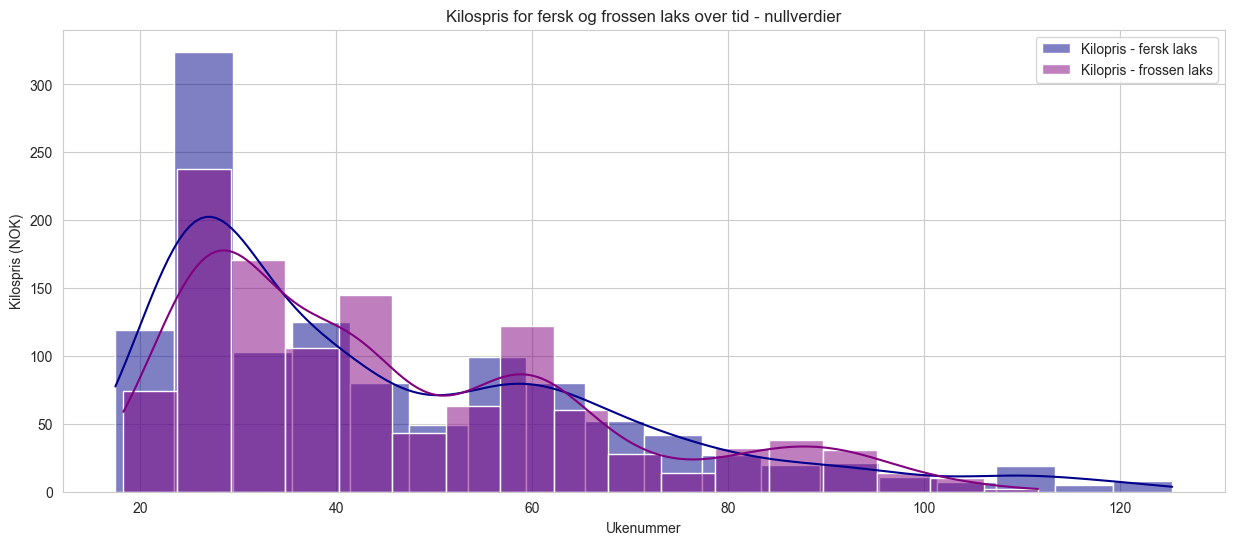

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt


# Opprette en scatterplot-figur
fig, ax = plt.subplots(figsize=(15, 6))
sns.set_style(style="whitegrid")

df_pivot["Ukenummer"] = range(1, len(df_pivot) + 1)
sns.histplot(data=renset_data, x = "Fersk laks - Kilospris", color = "darkblue", kde = True, label = "Kilopris - fersk laks")
sns.histplot(data=renset_data, x = "Frosset laks - Kilospris", color = "purple", kde = True, label = "Kilopris - frossen laks")


# Legg til tittel og etiketter
ax.set_title("Kilospris for fersk og frossen laks over tid - nullverdier")
ax.set_xlabel("Ukenummer")
ax.set_ylabel("Kilospris (NOK)")
ax.legend() 

# Vis plottet
plt.show()



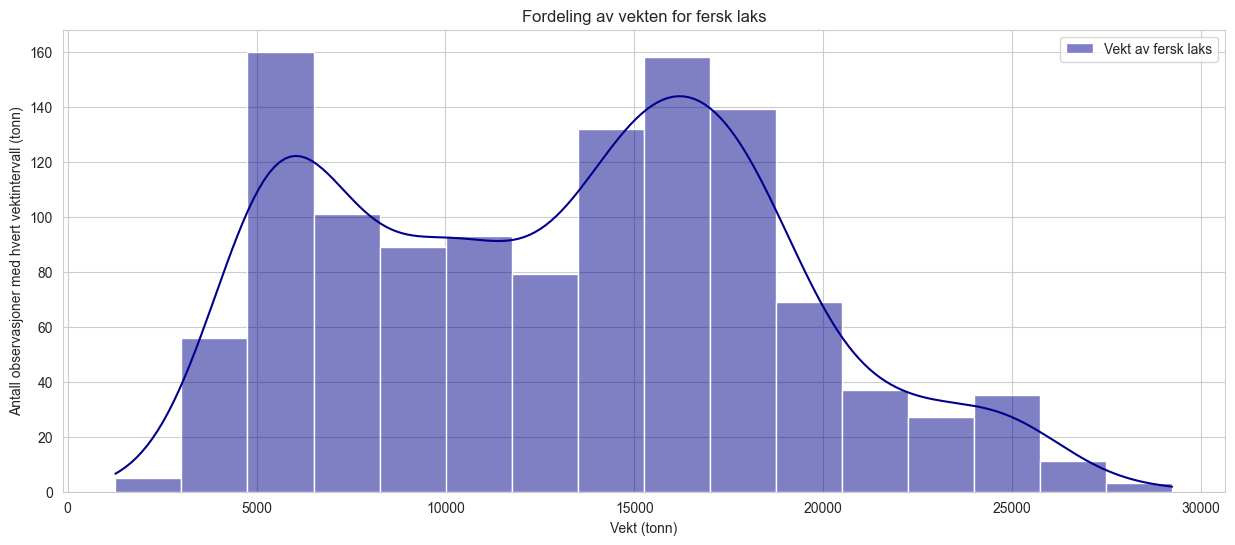

Grafen viser at vekten av fersk laks er normalfordelt og at det er flere uker med høyere vekt enn lavere vekt. 
Man ser også at det er mange tilfeller av laks med vekt rundt 5000 og vekt rundt 15000 tonn. 
Det er og en del laks mellom som har mindre forskjeller i vekten.
Grafen viser på y-aksen hvor mange uker hvor var tallet på y-aksen.


In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.histplot(data=renset_data, x = "Fersk laks - Vekt (tonn)", color = "darkblue", kde = True, label = "Vekt av fersk laks")

ax.set_title("Fordeling av vekten for fersk laks")
ax.set_xlabel("Vekt (tonn)")
ax.set_ylabel("Antall observasjoner med hvert vektintervall (tonn)")
ax.legend()


plt.show()

print("Grafen viser at vekten av fersk laks er normalfordelt og at det er flere uker med høyere vekt enn lavere vekt. \n" \
      "Man ser også at det er mange tilfeller av laks med vekt rundt 5000 og vekt rundt 15000 tonn. \n"\
         "Det er og en del laks mellom som har mindre forskjeller i vekten.\n"\
             "Grafen viser på y-aksen hvor mange uker hvor var tallet på y-aksen.\n"\ 
              "ekstremt høye vektverdier er mye sjeldnere" )